# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

##  Project F: Measuring the Shape and Brightness of Galaxies with Neural Networks
### Ideation 3
### Group 75: Dmitry Vukolov, Ning Xu, Rohit Beri, Sunil Chomal


**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Pavlos Protopapas, Mark Glickman and Chris Tanner<br/>


<hr style="height:2pt">

---



In [1]:
# RUN THIS CELL
import requests
from IPython.core.display import HTML, display

styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

## <div class="theme"> Outline </div> 

1. Overview
2. Loading the Data
3. Structure and Size of the Data
4. Basic Statistics of the Data 
5. Visualization of the Image Data 
6. Distributions of the Labels and Numerical Attributes 
7. Parametric Image Generation
8. Summary

## <div class="theme"> Overview </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## Creating Galaxy images using Galsim

### <div class='exercise'> <b> Step 0: Load the essential libraries </b> </div>

In [2]:
# Load useful libraries
import os
import sys
import copy
import math
import time
import random
import numpy as np
import pandas as pd
import ipywidgets as widgets

# Import h5py for reading h5 files
import h5py

# Load galsim for data generation
import galsim

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Tweak plot resolution and styling
%config InlineBackend.figure_format = "retina"
sns.set(style="white", palette=None, rc={"axes.linewidth": 1})
plt.rc("image", cmap="viridis")

In [3]:
# Load useful libraries
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import EarlyStopping

### <div class='exercise'> <b> Step 1: Load the data </b> </div>

In [4]:
# Read the data set
dataset = "./cs109b-project/data/data_v1.npz"

with np.load(dataset) as data:
    print("Available variables:", data.files)

    image = data["img"]
    image_nonoise = data["img_nonoise"]
    label = data["label"]
    snr = data["snr"]
    sigma = data["sigma"]
    psf = data["psf_r"]

Available variables: ['img', 'img_nonoise', 'label', 'psf_r', 'snr', 'sigma', 'train_test']


In [5]:
# Reshape images to 3D array
image = image.reshape(image.shape[0], image.shape[1], image.shape[2], 1)
image_nonoise = image_nonoise.reshape(image_nonoise.shape[0], image_nonoise.shape[1], image_nonoise.shape[2], 1)

# Split into 90% train and 10% test (creates a view of the array)
n_train = int(label.shape[0] * 0.9)
image_train, image_val = image[:n_train], image[n_train:]
image_nonoise_train, image_nonoise_val = image_nonoise[:n_train], image_nonoise[n_train:]
label_train, label_val = label[:n_train], label[n_train:]
snr_train, snr_val = snr[:n_train], snr[n_train:]
sigma_train, sigma_val = sigma[:n_train], sigma[n_train:]
psf_train, psf_val = psf[:n_train], psf[n_train:]


# Zero-One Normalization of the labels
label_min = label.min(axis=0)
label_max = label.max(axis=0)
label_diff = (label_max - label_min)

label_train = (label_train - label_min)/label_diff
label_val = (label_val - label_min)/label_diff


# Zero-One Normalization of the sigma
sigma_min = sigma.min(axis=0)
sigma_max = sigma.max(axis=0)
sigma_diff = (sigma_max - sigma_min)
sigma_diff = 1 if sigma_diff==0 else sigma_diff

sigma_train = ((sigma_train - sigma_min)/sigma_diff).reshape(-1,1)
sigma_val = ((sigma_val - sigma_min)/sigma_diff).reshape(-1,1)


# Zero-One Normalization of the PSF
psf_min = psf.min(axis=0)
psf_max = psf.max(axis=0)
psf_diff = (psf_max - psf_min)
psf_diff = 1 if psf_diff==0 else psf_diff

psf_train = ((psf_train - psf_min)/psf_diff).reshape(-1,1)
psf_val = ((psf_val - psf_min)/psf_diff).reshape(-1,1)


# Zero-One Normalization of the no-noise images
image_nonoise_min = image_nonoise.min()
image_nonoise_max = image_nonoise.max()
image_nonoise_diff = (image_nonoise_max - image_nonoise_min)

image_nonoise_train = (image_nonoise_train - image_nonoise_min)/image_nonoise_diff
image_nonoise_val = (image_nonoise_val - image_nonoise_min)/image_nonoise_diff


# Zero-One Normalization of the noisy images
image_min = image.min()
image_max = image.max()
image_diff = (image_max - image_min)

image_train = (image_train - image_min)/image_diff
image_val = (image_val - image_min)/image_diff

### <div class='exercise'> <b> Step 2: Structure and Size of the Data </b> </div>

In [6]:
# Structure and Size of the Data
print("Image Shape            = {}".format(image.shape))
print("No-noise Image Shape   = {}".format(image_nonoise.shape))
print("Label Shape            = {}".format(label.shape))
print("SNR Shape              = {}".format(snr.shape))
print("Sigma Shape            = {}".format(sigma.shape))
print("PSF-R Shape            = {}".format(psf.shape))

Image Shape            = (200000, 64, 64, 1)
No-noise Image Shape   = (200000, 64, 64, 1)
Label Shape            = (200000, 5)
SNR Shape              = (200000,)
Sigma Shape            = (200000,)
PSF-R Shape            = (200000,)


### <div class='exercise'> <b> Step 3: Basic Statistics of the Data </b> </div>

In [7]:
# Gather the image and attribute tables for processing
tables = {
    "Image": image,
    "No-noise Image": image_nonoise,
    "SNR": snr,
    "Sigma": sigma,
    "PSF-R": psf,
}
# Map each of the five labels to their names
labels = pd.DataFrame(label, columns=["Flux", "Sersic Index", "Sersic Radius", "g1", "g2"])

# Compute basic statistics
stats = {name: [data.mean(), data.var(), data.min(), data.max()] for name, data in tables.items()}
pd.concat(
    [
        pd.DataFrame.from_dict(stats, orient="index", columns=["mean", "var", "min", "max"]),
        labels.agg(["mean", "var", "min", "max"]).T,
    ]
).rename_axis("Data Type").rename(columns=lambda x: x.title()).round(2)

,Mean,Var,Min,Max
Data Type,,,,
Image,26.12,7.813868e+04,-1197.36,8133.71
No-noise Image,26.12,3.810756e+04,-0.15,7783.52
SNR,58.23,5.812000e+02,12.23,100.00
Sigma,200.00,0.000000e+00,200.00,200.00
PSF-R,0.50,0.000000e+00,0.50,0.50
Flux,108535.80,2.378915e+09,30000.67,251822.86
Sersic Index,3.25,2.530000e+00,0.50,6.00
Sersic Radius,0.38,2.000000e-02,0.10,0.60
g1,0.00,8.000000e-02,-0.67,0.67


### <div class='exercise'> <b> Step 4: Create Data Pipeline </b> </div>

In [8]:
# Create Tensorflow Dataset
training = tf.data.Dataset.from_tensor_slices({
    "Image": image_train,
    "No-noise Image": image_nonoise_train,
    "Labels": np.hstack([label_train, sigma_train, psf_train]),
})

validation = tf.data.Dataset.from_tensor_slices({
    "Image": image_val,
    "No-noise Image": image_nonoise_val,
    "Labels": np.hstack([label_val, sigma_val, psf_val]),
})

In [9]:
def pipeline_label_to_clean_image(element):
    image = element['No-noise Image']
    label = tf.cast(element['Labels'], tf.float32)
                     
    return (label, image)

In [10]:
def pipeline_noisy_image_to_label(element):
    image = element['Image']
    label = tf.cast(element['Labels'], tf.float32)
    
    return (image, label)

In [11]:
def pipeline_noisy_image_to_clean_image(element):
    image = element['Image']
    label = tf.cast(element['Labels'], tf.float32)
    clean = element['No-noise Image']
    
    return (image, (clean, label))

In [12]:
# Batch Size
batch_size = 256


# Data pipeline for Decoder
tr_ds = training.map(
    pipeline_label_to_clean_image).shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = validation.map(
    pipeline_label_to_clean_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Data pipeline for Encoder
tr_ds_en = training.map(
    pipeline_noisy_image_to_label).shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds_en = validation.map(
    pipeline_noisy_image_to_label).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


# Data pipeline for AE
tr_ds_AE = training.map(
    pipeline_noisy_image_to_clean_image).shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds_AE = validation.map(
    pipeline_noisy_image_to_clean_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

### <div class='exercise'> <b> Step 5: Create Label to Image Decoder </b> </div>

In [13]:
K.clear_session()

# Encoder Inout Dimension
input_shape = (64,64,1)

# Dropout rate for dense layers
dropout = 0.5

# Encoder Output dimension - Decoder Input Dimension
latent_z_dim = 7

# Decoder latent dimension
latent_dim = (1,1,2048)

# Number of Training Epochs
epochs = 20

In [14]:
class ConvEncoder(layers.Layer):
    """
    Convolutional Encoder Layer Class.
    Converts an input into a latent representation.
    """

    def __init__(self, input_shape, dropout_rate=0.0, name='encoder', **kwargs):
        """
        Initializes the encoder layers and saves them as local attribute.
        
        Input:
        -input_dim: 3D-tuple with (rows, cols, channels) input image dimensions.
        
        Returns nothing.
        """
        super(ConvEncoder, self).__init__(name=name, input_shape=input_shape, **kwargs)
        
        ## your code here
        
        self.conv1 = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu1 = layers.LeakyReLU()
        self.drop1 = layers.Dropout(dropout_rate)
        
        self.conv2 = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu2 = layers.LeakyReLU()
        self.drop2 = layers.Dropout(dropout_rate)
        
        self.conv3 = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu3 = layers.LeakyReLU()
        self.drop3 = layers.Dropout(dropout_rate)
        
        self.conv4 = layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu4 = layers.LeakyReLU()
        self.drop4 = layers.Dropout(dropout_rate)
        
        self.conv5 = layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu5 = layers.LeakyReLU()
        self.drop5 = layers.Dropout(dropout_rate)
        
        self.conv6 = layers.Conv2D(filters=2048, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu6 = layers.LeakyReLU()
        self.drop6 = layers.Dropout(dropout_rate)
        
        # end of your code here
        

    def call(self, inputs, training=None):
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 4D-tensor with dimension (batch_size, self.input_dim).
        """
        ## your code here
        
        z = self.conv1(inputs)
        z = self.lRelu1(z)
        z = self.drop1(z)
        
        z = self.conv2(z)
        z = self.lRelu2(z)
        z = self.drop2(z)
        
        z = self.conv3(z)
        z = self.lRelu3(z)
        z = self.drop3(z)
        
        z = self.conv4(z)
        z = self.lRelu4(z)
        z = self.drop4(z)
        
        z = self.conv5(z)
        z = self.lRelu5(z)
        z = self.drop5(z)
        
        z = self.conv6(z)
        z = self.lRelu6(z)
        z = self.drop6(z)
        
        # end of your code here
        return z

In [15]:
class ConvDecoder(layers.Layer):
    """
    Convolutional Decoder Layer Class.
    Converts z, the encoded digit vector, back into a readable digit.
    """

    def __init__(self, input_shape, dropout_rate=0.0, name='decoder', **kwargs):
        """
        Initializes the decoder architecture and saves it as a local attribute.
        
        Input:
        -input_shape: 3D-tuple with (rows, cols, channels) input representation.
        
        Returns nothing.
        """
        super(ConvDecoder, self).__init__(name=name, input_shape=input_shape, **kwargs)
        
        # your code here
        self.convT1 = layers.Conv2DTranspose(512, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu1 = layers.LeakyReLU()
        self.drop1 = layers.Dropout(dropout_rate)
        
        self.convT2 = layers.Conv2DTranspose(256, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu2 = layers.LeakyReLU()
        self.drop2 = layers.Dropout(dropout_rate)
        
        self.convT3 = layers.Conv2DTranspose(128, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu3 = layers.LeakyReLU()
        self.drop3 = layers.Dropout(dropout_rate)
        
        self.convT4 = layers.Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu4 = layers.LeakyReLU()
        self.drop4 = layers.Dropout(dropout_rate)
        
        self.convT5 = layers.Conv2DTranspose(32, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu5 = layers.LeakyReLU()
        self.drop5 = layers.Dropout(dropout_rate)
        
        self.convT6 = layers.Conv2DTranspose(1, kernel_size=(3,3), strides=(2,2), padding='same', 
                                             activation='sigmoid')
        # end of your code here
        

    def call(self, inputs, training=None):
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 4D-tensor with dimension (batch_size, self.input_dim).
        """
        ## your code here
        
        x = self.convT1(inputs)
        x = self.lRelu1(x)
        x = self.drop1(x)
        
        x = self.convT2(x)
        x = self.lRelu2(x)
        x = self.drop2(x)
        
        x = self.convT3(x)
        x = self.lRelu3(x)
        x = self.drop3(x)
        
        x = self.convT4(x)
        x = self.lRelu4(x)
        x = self.drop4(x)
        
        x = self.convT5(x)
        x = self.lRelu5(x)
        x = self.drop5(x)
        
        x = self.convT6(x)
        
        # end your code here
        return x

In [16]:
# Create Reverse Decoder Model
def create_reverse_decoder():

    # Create Reverse Decoder
    input_decoder = layers.Input(latent_z_dim)
    x = layers.Dense(1024)(input_decoder)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(2048)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Reshape(latent_dim)(x)
    recon = ConvDecoder(latent_dim)(x)
    
    # Decoder Model
    decoder = tf.keras.Model(input_decoder, recon, name='Reverse_Decoder')
    display(decoder.summary())
    
    # Compile the model
    optimizer = optimizers.Adam(learning_rate=0.001)
    decoder.compile(optimizer, loss=losses.BinaryCrossentropy())
    
    # Return reverse decoder
    return decoder

reverse_decoder = create_reverse_decoder()

Model: "Reverse_Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 2048)    

None

In [17]:
# Run the model
try:
    reverse_decoder.load_weights('./model/rev_de3')
    
except:
    history = reverse_decoder.fit(
        tr_ds, 
        epochs=epochs, 
        verbose=1,
        validation_data=val_ds,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    
    reverse_decoder.save_weights('./model/rev_de3')

Epoch 1/20
704/704 [==============================] - 167s 237ms/step - loss: 0.0244 - val_loss: 0.0000e+00
Epoch 2/20
704/704 [==============================] - 163s 232ms/step - loss: 0.0121 - val_loss: 0.0121
Epoch 3/20
704/704 [==============================] - 162s 231ms/step - loss: 0.0121 - val_loss: 0.0121
Epoch 4/20
704/704 [==============================] - 163s 231ms/step - loss: 0.0121 - val_loss: 0.0121
Epoch 5/20
704/704 [==============================] - 163s 231ms/step - loss: 0.0120 - val_loss: 0.0121
Epoch 6/20
704/704 [==============================] - 163s 232ms/step - loss: 0.0120 - val_loss: 0.0121
Epoch 7/20
704/704 [==============================] - 162s 231ms/step - loss: 0.0120 - val_loss: 0.0121
Epoch 8/20
704/704 [==============================] - 163s 231ms/step - loss: 0.0120 - val_loss: 0.0121
Epoch 9/20
704/704 [==============================] - 162s 231ms/step - loss: 0.0120 - val_loss: 0.0121
Epoch 10/20
704/704 [==============================] - 163s 

In [18]:
test = val_ds.take(1)
labels, images = next(iter(test))
pred = reverse_decoder.predict(labels)
pred = pred.reshape(pred.shape[:-1])

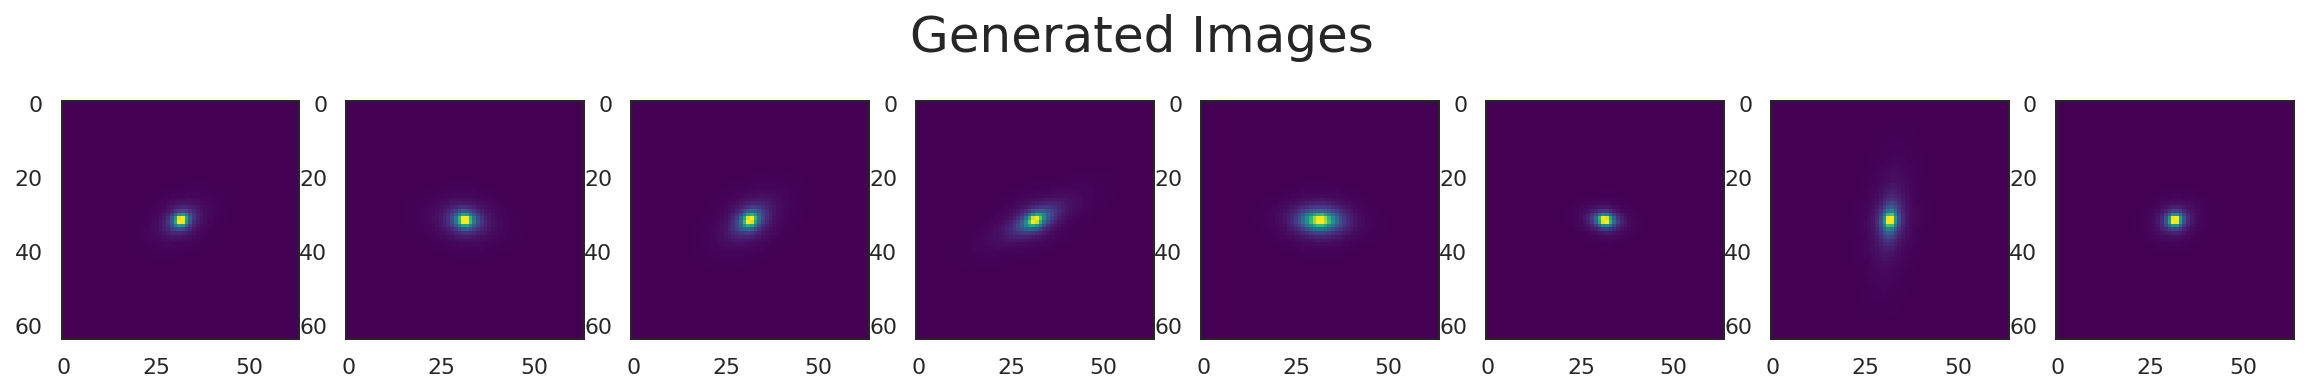

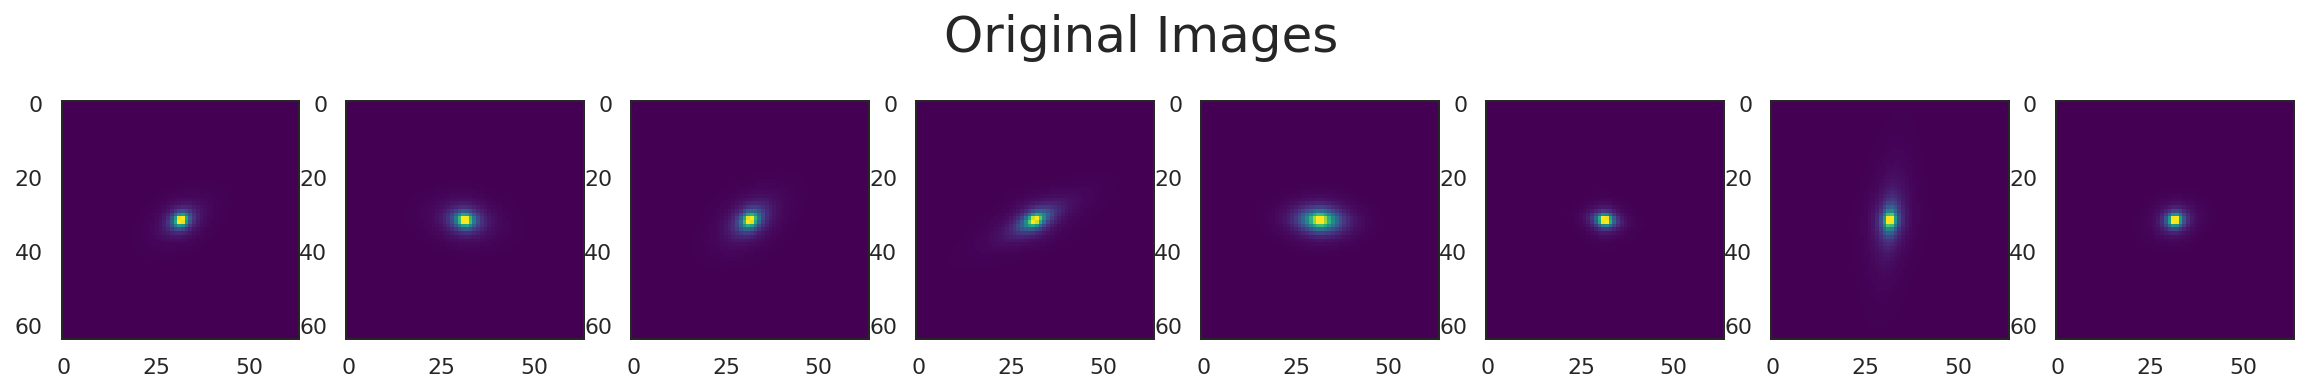

In [19]:
idx = np.random.randint(256*1, size=8)

fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Generated Images", fontsize=25)
for j in range(8):
    ax[j].imshow(pred[idx[j]])
plt.show()


fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Original Images", fontsize=25)
for j in range(8):
    ax[j].imshow(images[idx[j]].numpy().reshape(64,64))
plt.show()

### <div class='exercise'> <b> Step 6: Create Image to Label Encoder </b> </div>

In [20]:
# Create Reverse Decoder Model
def create_reverse_encoder():

    # Create Reverse Encoder
    input_encoder = layers.Input(input_shape)
    x = ConvEncoder(input_shape)(input_encoder)
    x = layers.Flatten()(x)
    x = layers.Dense(2048)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(1024)(x)
    x = layers.Dropout(dropout)(x)
    latent_z = layers.Dense(latent_z_dim, activation='sigmoid')(x)
    
    
    # Encoder Model
    encoder = tf.keras.Model(input_encoder, latent_z, name='Reverse_Encoder')
    display(encoder.summary())
    
    # Compile the model
    optimizer = optimizers.Adam(learning_rate=0.001)
    encoder.compile(optimizer, loss=losses.MeanSquaredError())
    
    # Return reverse decoder
    return encoder

reverse_encoder = create_reverse_encoder()

Model: "Reverse_Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
encoder (ConvEncoder)        (None, 1, 1, 2048)        11007232  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 2048)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)          

None

In [21]:
# Run the model
try:
    reverse_encoder.load_weights('./model/rev_en3')
    
except:
    history = reverse_encoder.fit(
        tr_ds_en, 
        epochs=epochs, 
        verbose=1,
        validation_data=val_ds_en,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    
    reverse_encoder.save_weights('./model/rev_en3')

Epoch 1/20
704/704 [==============================] - 156s 221ms/step - loss: 0.0226 - val_loss: 0.0000e+00
Epoch 2/20
704/704 [==============================] - 155s 220ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 3/20
704/704 [==============================] - 155s 220ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 4/20
704/704 [==============================] - 155s 220ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 5/20
704/704 [==============================] - 155s 220ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 6/20
704/704 [==============================] - 154s 219ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 7/20
704/704 [==============================] - 151s 214ms/step - loss: 0.1097 - val_loss: 0.2363
Epoch 8/20
704/704 [==============================] - 144s 205ms/step - loss: 0.2369 - val_loss: 0.2363
Epoch 9/20
704/704 [==============================] - 144s 205ms/step - loss: 0.2369 - val_loss: 0.2363
Epoch 10/20
704/704 [==============================] - 144s 

In [22]:
test = val_ds_en.take(1)
images, labels = next(iter(test))
pred = reverse_encoder.predict(images)

In [23]:
i = 1

print("Pred:   ",pred[i])
print("Orignal:",labels[i].numpy())
print(np.sum(pred[i]-labels[i].numpy())**2)

Pred:    [3.8937622e-01 2.7131888e-01 5.5209666e-01 6.9393253e-01 5.8889914e-01
 1.0547042e-04 1.0392070e-04]
Orignal: [0.42072448 0.43843845 0.638038   0.72692305 0.5686976  0.
 0.        ]
0.08820228546856956


In [24]:
label_val = np.hstack([label_val, sigma_val, psf_val])
label_diff = np.hstack([label_diff, sigma_diff, psf_diff])
label_min = np.hstack([label_min, sigma_min, psf_min])

pred = (reverse_encoder.predict(val_ds_en) * label_diff) + label_min

In [25]:
label_unscaled = (label_val* label_diff) + label_min
error = pred - label_unscaled

In [26]:
MSE = (error**2).mean(axis=0)
RMSE = np.sqrt(MSE)

label_var = label_unscaled.std(axis=0)**2

unexplained_var = MSE/label_var

/usr/share/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [27]:
1 - unexplained_var

array([0.97777601, 0.74274502, 0.87323647, 0.91775748, 0.91149811,
             -inf,       -inf])

In [28]:
np.set_printoptions(suppress=True)
RMSE

array([7266.45742362,    0.80759981,    0.05006568,    0.08004733,
          0.08251968,    0.00011072,    0.00010481])

### <div class='exercise'> <b> Step 6: Create and fine-tune Auto-Encoder </b> </div>

In [29]:
def create_reverse_AE():
    input_encoder = layers.Input(input_shape)
    labels = reverse_encoder(input_encoder)
    recons = reverse_decoder(labels)
    
    # Reverse AE Model
    reverse_AE = tf.keras.Model(input_encoder, [recons, labels], name='Reverse_AE')
    display(reverse_AE.summary())
    
    # Compile the model
    optimizer = optimizers.Adam(learning_rate=0.001)
    reverse_AE.compile(optimizer, loss=losses.BinaryCrossentropy())
    
    # Return reverse decoder
    return reverse_AE

reverse_AE = create_reverse_AE()

Model: "Reverse_AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
Reverse_Encoder (Model)      (None, 7)                 17308935  
_________________________________________________________________
Reverse_Decoder (Model)      (None, 64, 64, 1)         13112577  
Total params: 30,421,512
Trainable params: 30,421,512
Non-trainable params: 0
_________________________________________________________________


None

In [30]:
# Run the model
try:
    reverse_AE.load_weights('./model/rev_AE3')
    
except:
    history = reverse_AE.fit(
        tr_ds_AE, 
        epochs=epochs, 
        verbose=1,
        validation_data=val_ds_AE,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    
    reverse_AE.save_weights('./model/rev_AE3')

Epoch 1/20
704/704 [==============================] - 321s 456ms/step - loss: 0.4185 - Reverse_Decoder_loss: 0.0121 - Reverse_Encoder_loss: 0.4064 - val_loss: 0.0000e+00 - val_Reverse_Decoder_loss: 0.0000e+00 - val_Reverse_Encoder_loss: 0.0000e+00
Epoch 2/20
704/704 [==============================] - 318s 452ms/step - loss: 0.4180 - Reverse_Decoder_loss: 0.0121 - Reverse_Encoder_loss: 0.4059 - val_loss: 0.4179 - val_Reverse_Decoder_loss: 0.0121 - val_Reverse_Encoder_loss: 0.4058
Epoch 3/20
704/704 [==============================] - 319s 454ms/step - loss: 0.4175 - Reverse_Decoder_loss: 0.0121 - Reverse_Encoder_loss: 0.4054 - val_loss: 0.4192 - val_Reverse_Decoder_loss: 0.0121 - val_Reverse_Encoder_loss: 0.4070
Epoch 4/20
704/704 [==============================] - 317s 450ms/step - loss: 1748.0399 - Reverse_Decoder_loss: 0.0162 - Reverse_Encoder_loss: 1745.5809 - val_loss: 14.6032 - val_Reverse_Decoder_loss: 0.0129 - val_Reverse_Encoder_loss: 14.5903
Epoch 5/20
704/704 [================

In [31]:
test = val_ds_AE.take(1)
images, (clean, labels) = next(iter(test))
pred_img, pred_lab = reverse_AE.predict(images)
pred = pred_img.reshape(pred_img.shape[:-1])

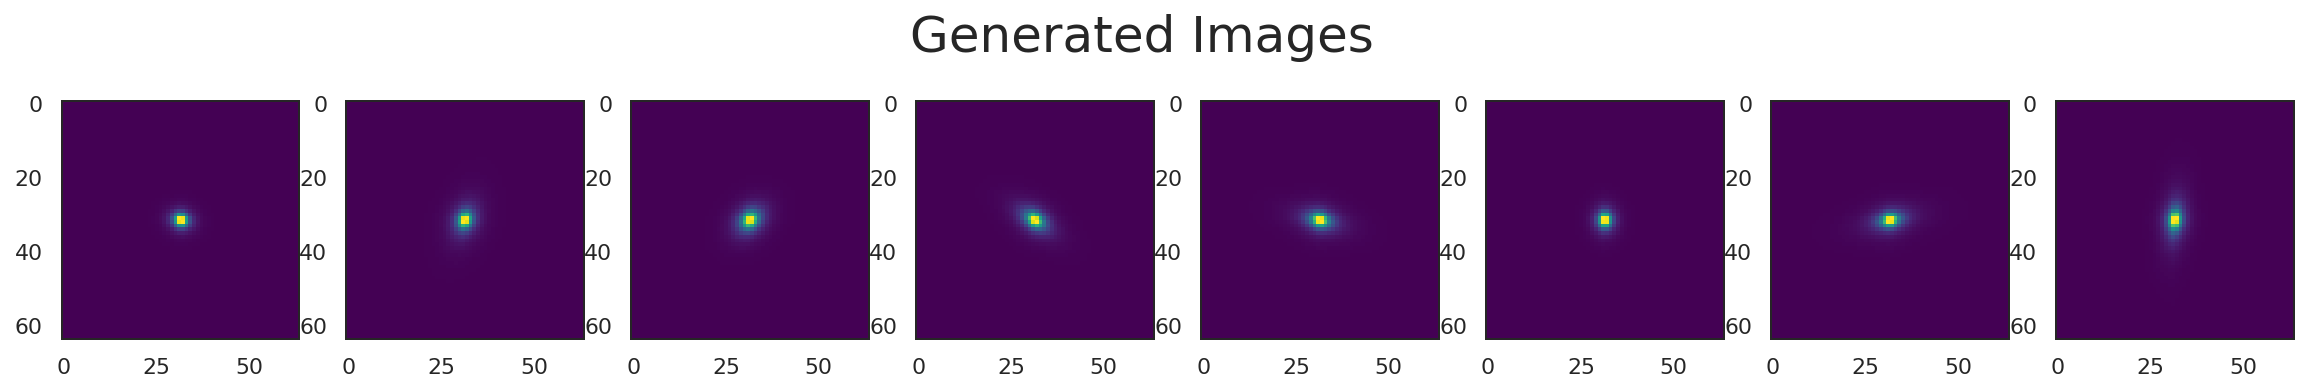

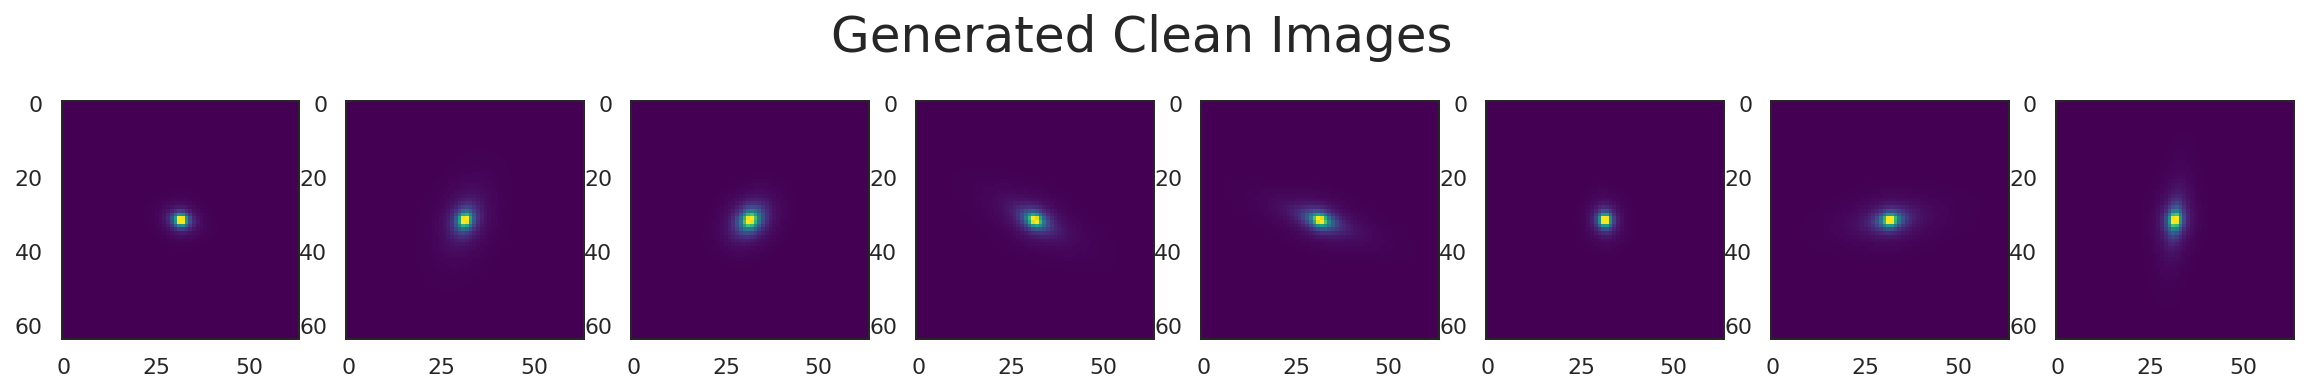

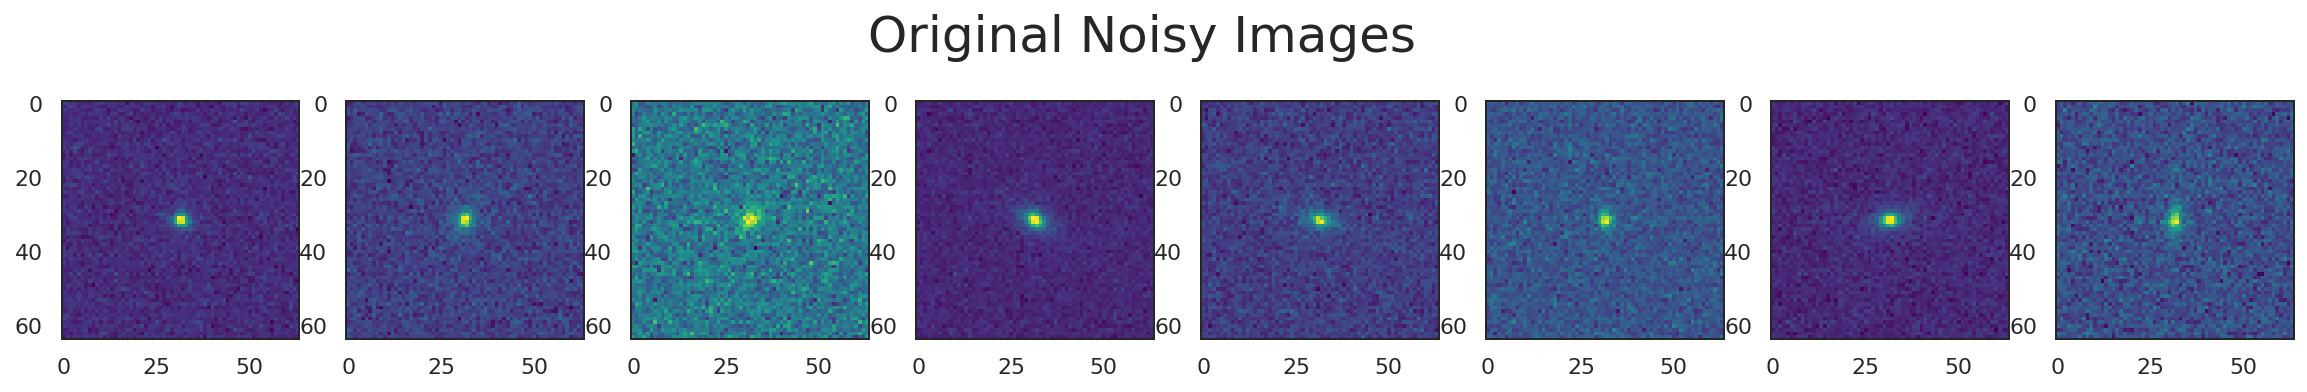

In [32]:
idx = np.random.randint(256*1, size=8)

fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Generated Images", fontsize=25)
for j in range(8):
    ax[j].imshow(pred[idx[j]])
plt.show()


fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Clean Images", fontsize=25)
for j in range(8):
    ax[j].imshow(clean[idx[j]].numpy().reshape(64,64))
plt.show()

fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Original Noisy Images", fontsize=25)
for j in range(8):
    ax[j].imshow(images[idx[j]].numpy().reshape(64,64))
plt.show()

In [33]:
i = 1

print("Pred:   ",pred_lab[i])
print("Orignal:",labels[i].numpy())
print(np.sum(pred_lab[i]-labels[i].numpy())**2)

Pred:    [0.38801098 0.23448566 0.56977206 0.6868264  0.55610865 0.0000017
 0.00000203]
Orignal: [0.42072448 0.43843845 0.638038   0.72692305 0.5686976  0.
 0.        ]
0.12788780187315751


In [34]:
_, pred = (reverse_AE.predict(val_ds_AE))
pred =  (pred * label_diff) + label_min

In [35]:
label_unscaled = (label_val* label_diff) + label_min
error = pred - label_unscaled

In [36]:
MSE = (error**2).mean(axis=0)
RMSE = np.sqrt(MSE)

label_var = label_unscaled.std(axis=0)**2

unexplained_var = MSE/label_var

/usr/share/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [37]:
1 - unexplained_var

array([0.97897493, 0.71947726, 0.87301613, 0.92328743, 0.92672059,
             -inf,       -inf])

In [38]:
np.set_printoptions(suppress=True)
RMSE

array([7067.7373724 ,    0.84333156,    0.05010917,    0.07730933,
          0.07508829,    0.00000116,    0.00000124])

<div class='gc'> <b> Select random images for visualization </b> </div>

## <div class="theme"> Summary </div> 

<div style="border: 3px solid #800080; padding: 10px"> 
    
### ***Shape and Brightness of a Galaxy***


# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png">  End of Exploratory Data Analysis 
